In [2]:
import cv2
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.layers import Flatten

In [55]:
training_file = 'train.p'
testing_file = 'test.p'

train = pickle.load(open(training_file, "rb"))
test = pickle.load(open(testing_file, "rb"))

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [56]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples
n_test = len(X_test)

# Shape of a traffic sign image
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train).union(set(y_test)))

print ("Number of training examples = {}".format(n_train))
print ("Number of testing examples = {}".format(n_test))
print ("Image data shape = {}".format(image_shape))
print ("Number of classes = {}".format(n_classes))

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
# Data exploration visualization
import matplotlib.pyplot as plt
%matplotlib inline

def class_distribution(y, title):
    n_classes = len(set(y))
    class_count = [0] * n_classes
    for n in y:
        class_count[n] += 1
    class_count_index = [0] * n_classes
    for i in range(n_classes):
        class_count_index[i] = i
    plt.figure(figsize=(12,4))
    plt.bar(range(len(class_count)), class_count)
    plt.xticks(range(len(class_count)), class_count_index)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

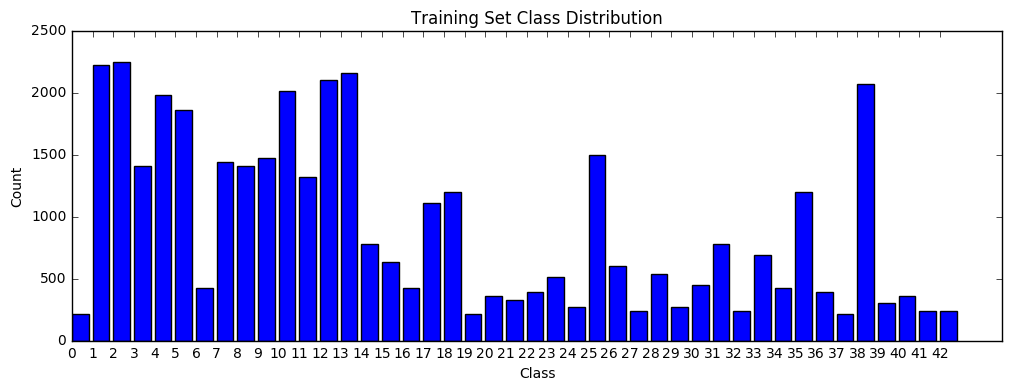

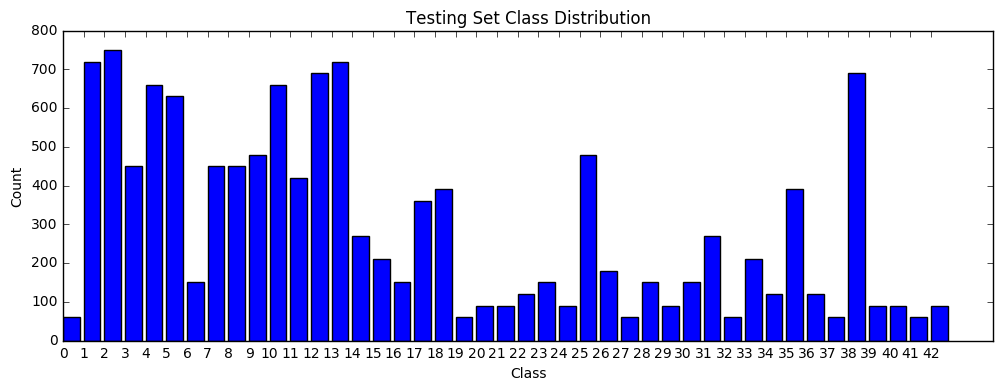

In [5]:
# Compare class distributions of training and test sets
class_distribution(y_train, 'Training Set Class Distribution')
class_distribution(y_test, 'Testing Set Class Distribution')

In [6]:
# plot RGB or grayscale images
def plot_images(X, y, image_indices, grayscale=False, title=None):
    for i in range(len(image_indices)):
        plt.figure()
        if title is None:
            plt.title("Class " + str(y[image_indices[i]]))
        else:
            plt.title(title)
        if not grayscale:
            plt.imshow(X[image_indices[i]])
        else:
            plt.imshow(X[image_indices[i]], cmap='gray')

/Users/aaroniglesias/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


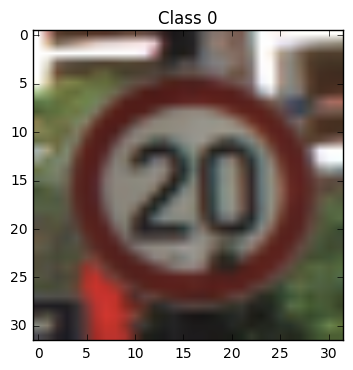

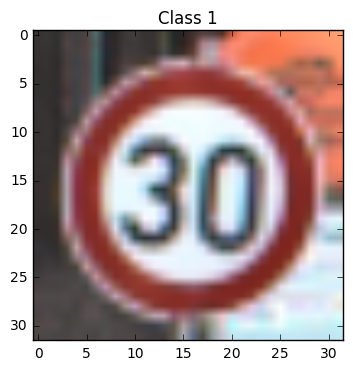

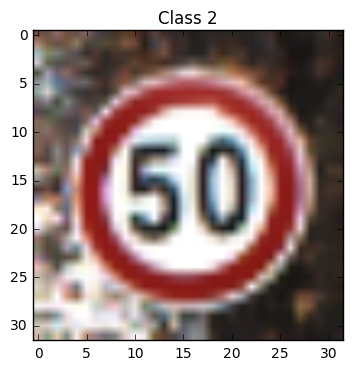

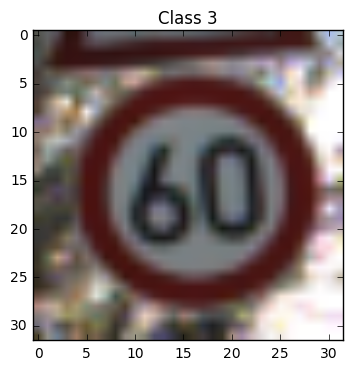

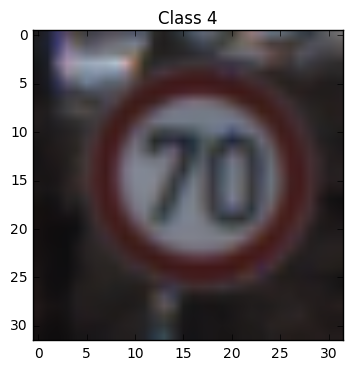

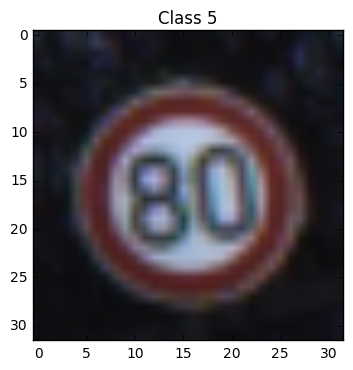

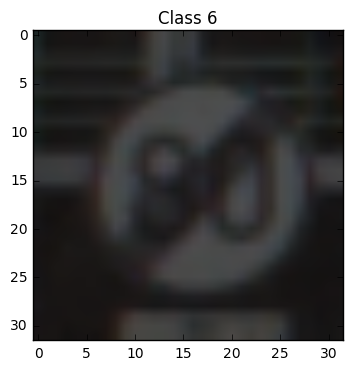

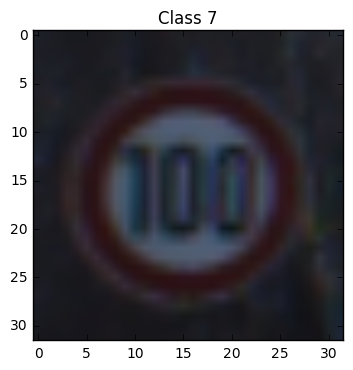

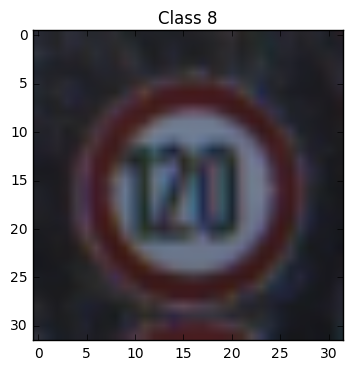

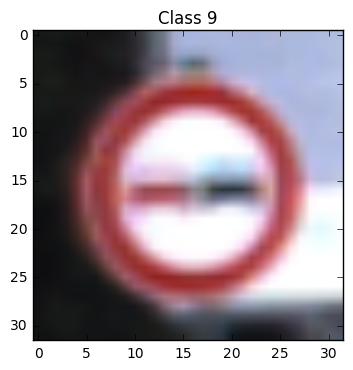

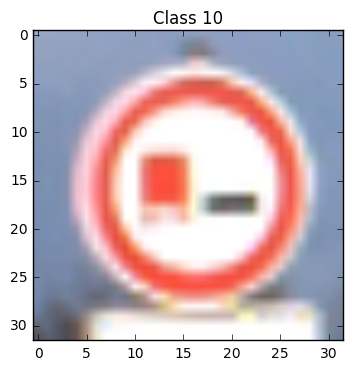

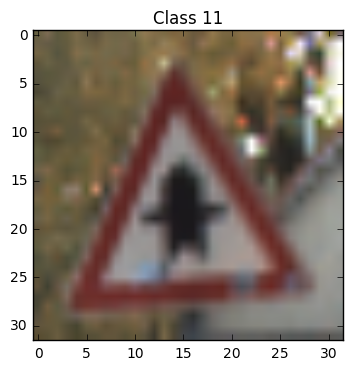

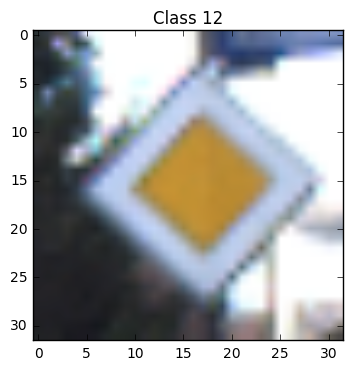

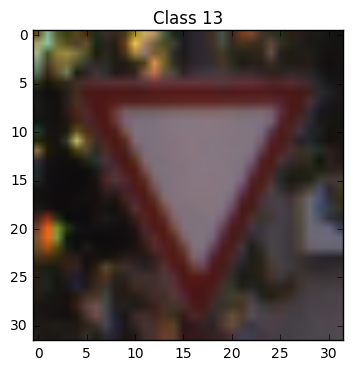

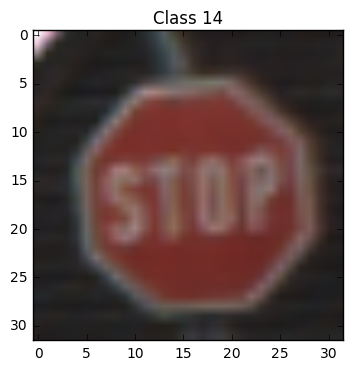

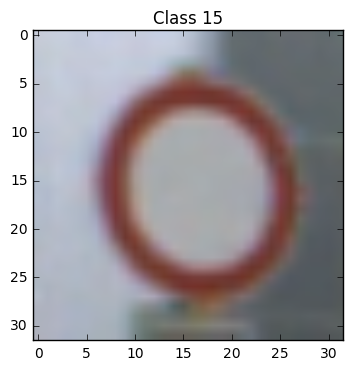

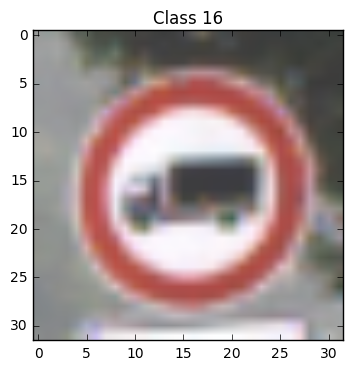

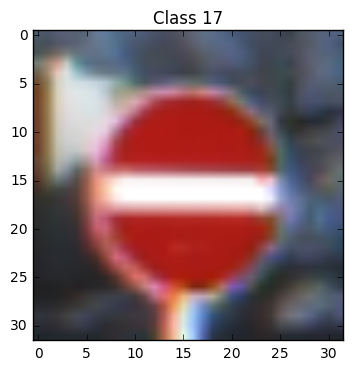

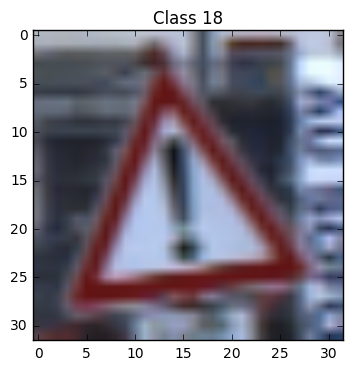

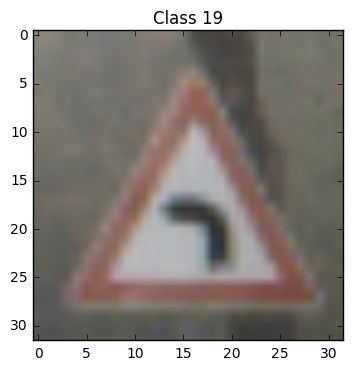

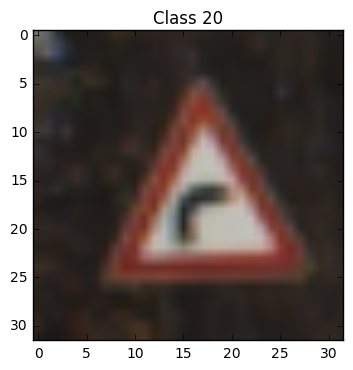

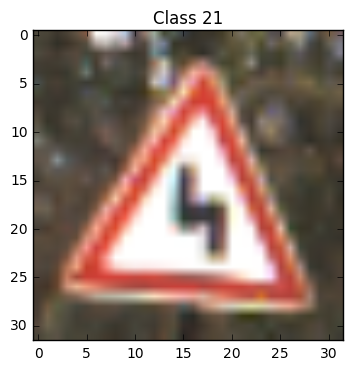

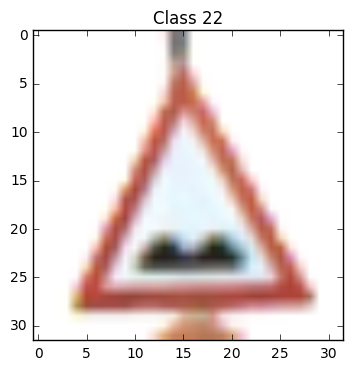

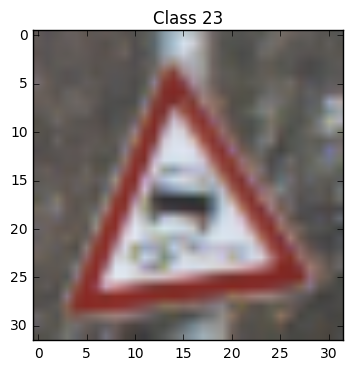

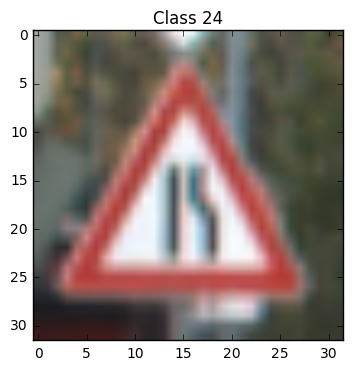

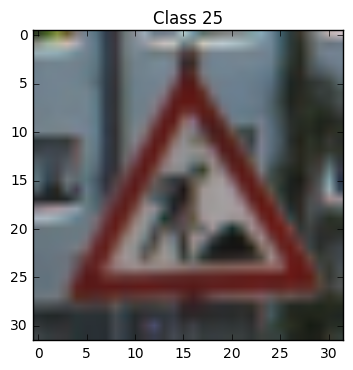

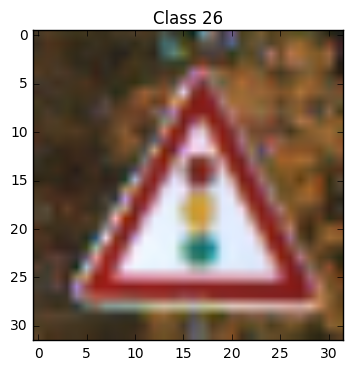

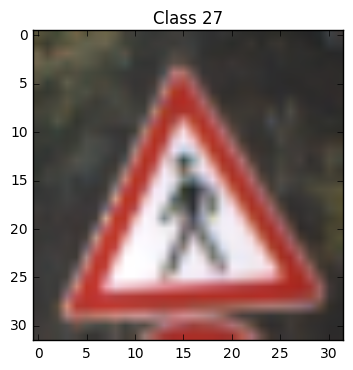

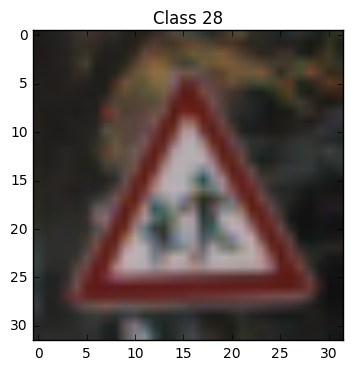

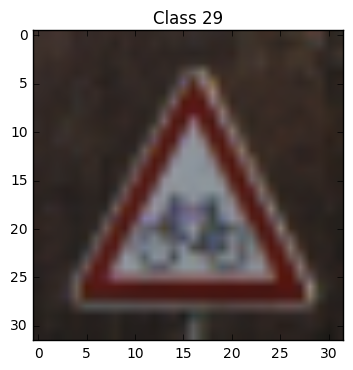

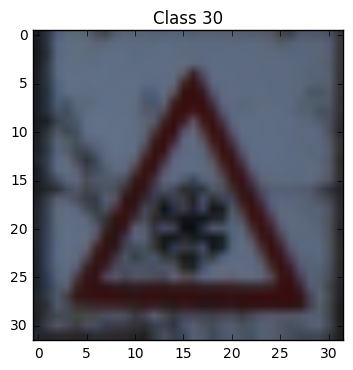

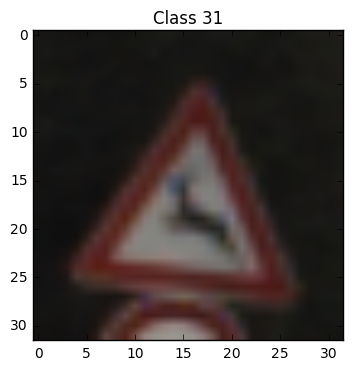

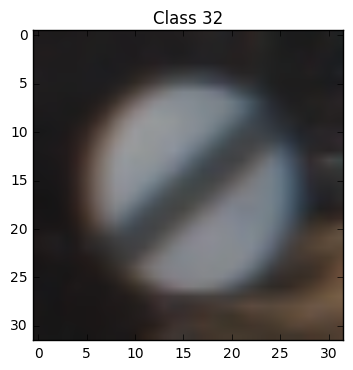

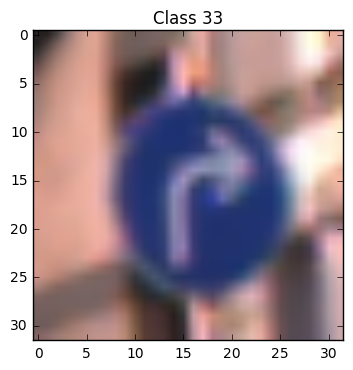

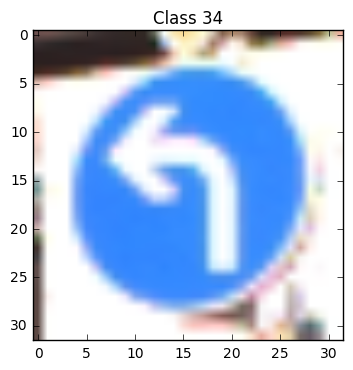

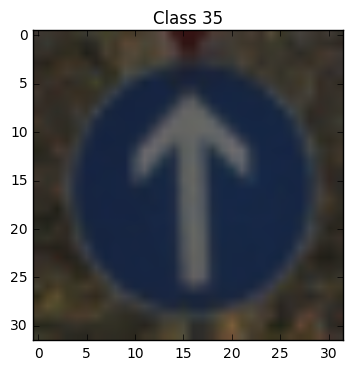

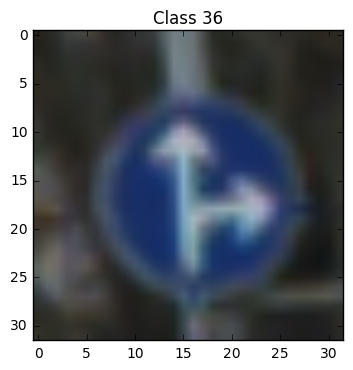

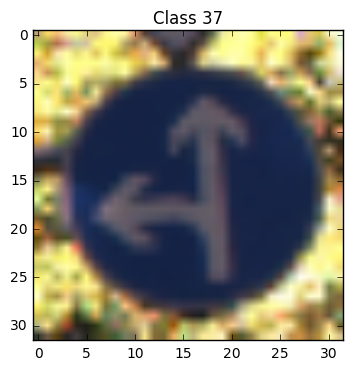

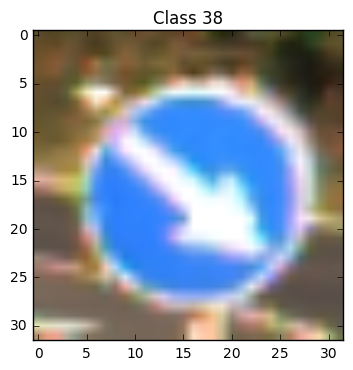

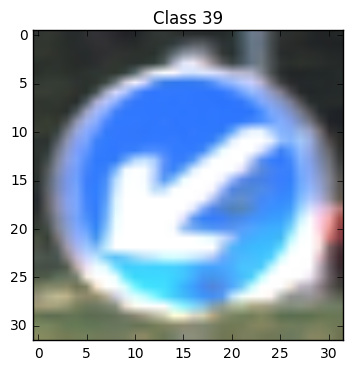

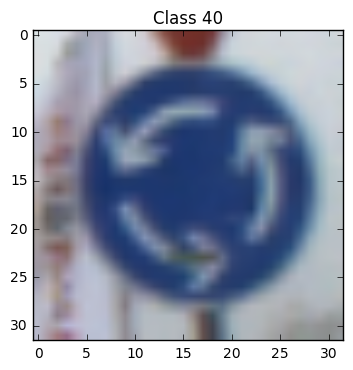

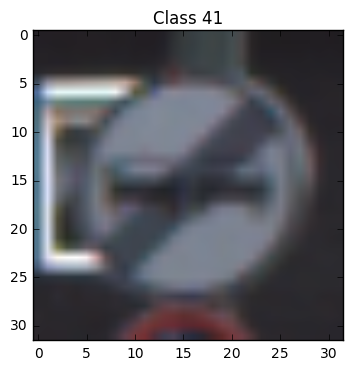

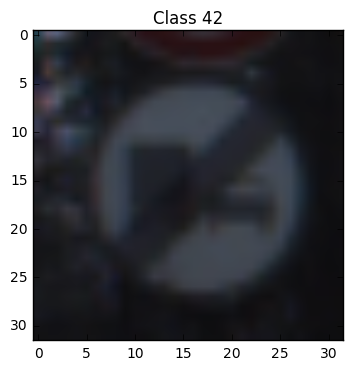

In [7]:
# plot one RGB image per class
clear_image_indices = [200, 2000, 4400, 5600, 8000, 9500, 10340, 11600, 13100, 14400, 16400, 17000,
                        19100, 20300, 23000, 23500, 23710, 24530, 26300, 26450, 26780, 27200, 27500,
                        28010, 28270, 29000, 30015, 30650, 31004, 31520, 31700, 32500, 32900, 33600,
                        33800, 35000, 35700, 35960, 36700, 38300, 38600, 38780, 39020]

plot_images(X_train, y_train, clear_image_indices)

In [8]:
###preprocessing images
# convert RGB images to grayscale
def grayscale(rgb_images):
    res = np.zeros(shape=(len(rgb_images), 
                          rgb_images.shape[1],
                          rgb_images.shape[2]))
    for i in range(len(rgb_images)):
        res[i] = cv2.cvtColor(rgb_images[i], cv2.COLOR_RGB2GRAY)
    return res

# scale image features to 0 mean and unit variance
def normalize(images):
    return (images - 128) / 128

In [9]:
# grayscale and normalize images

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

X_train_gray = normalize(X_train_gray)
X_test_gray = normalize(X_test_gray)

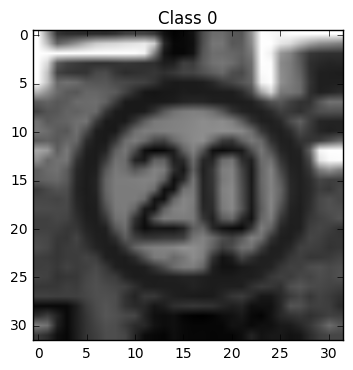

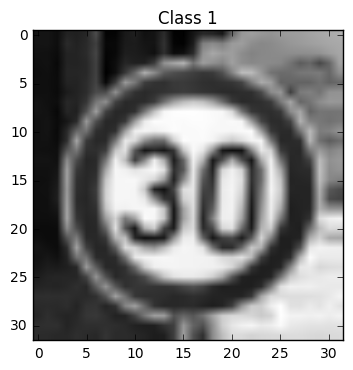

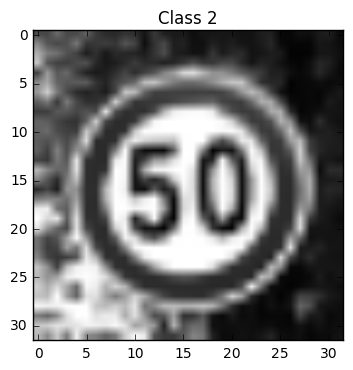

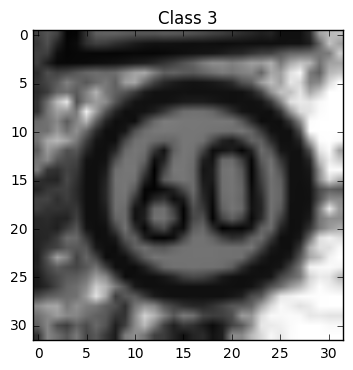

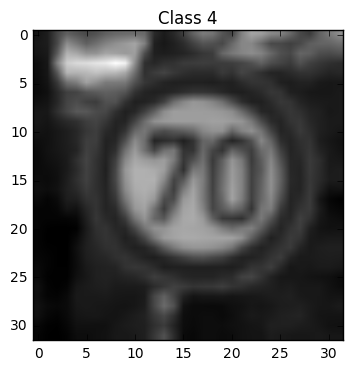

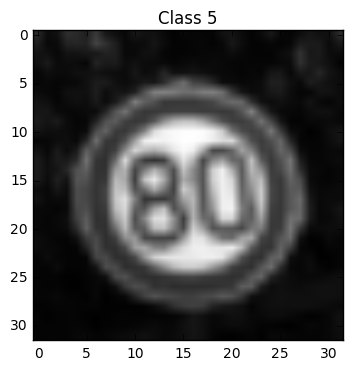

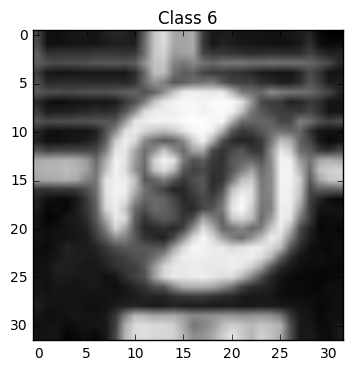

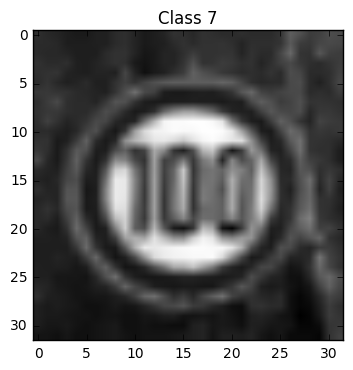

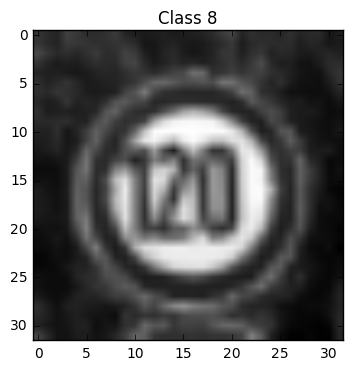

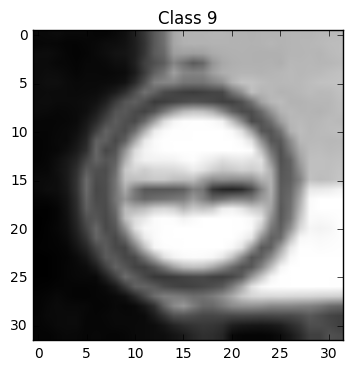

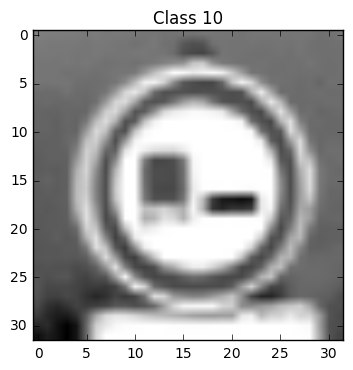

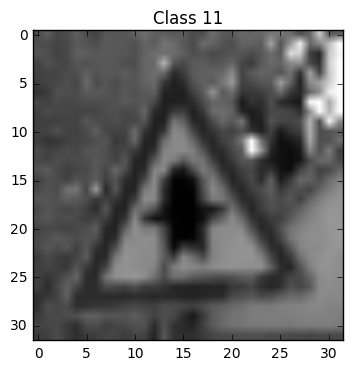

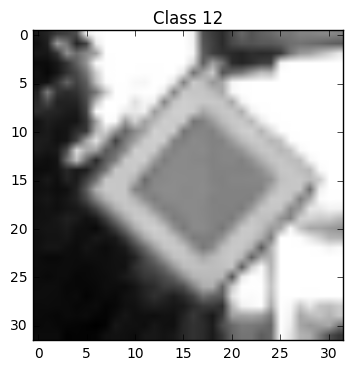

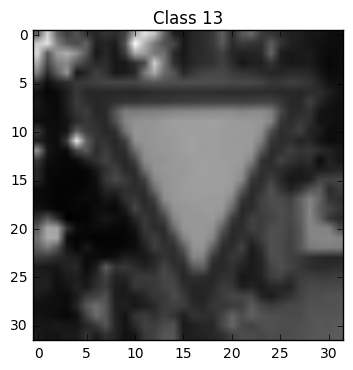

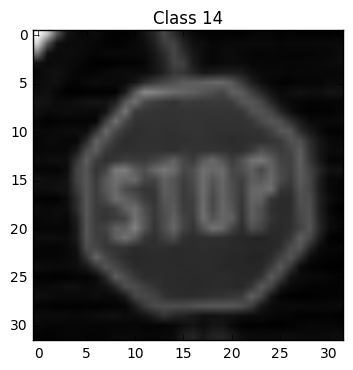

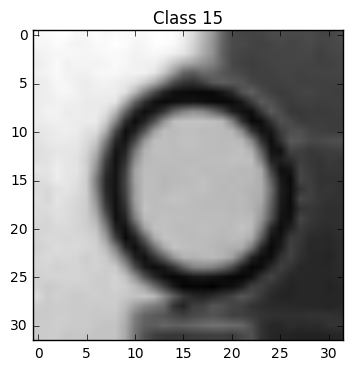

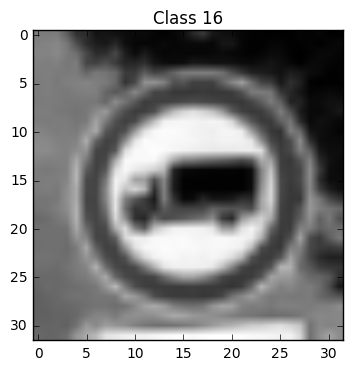

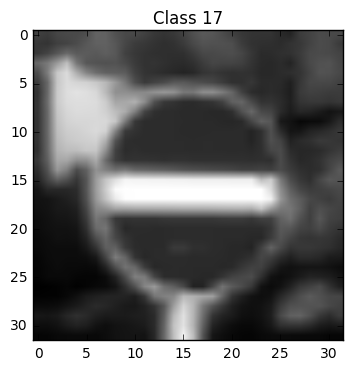

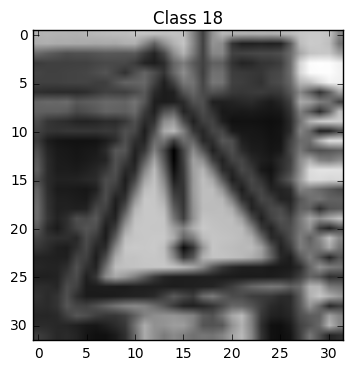

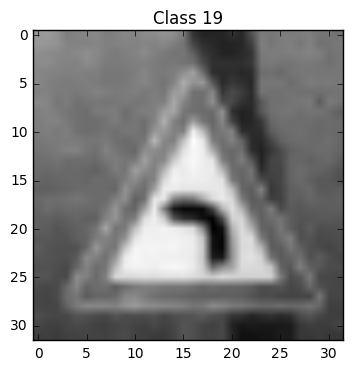

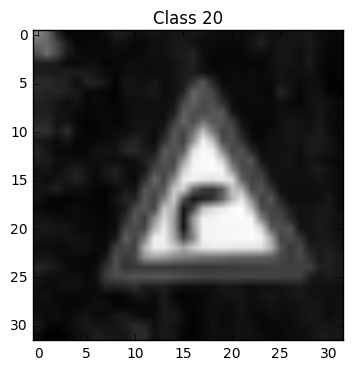

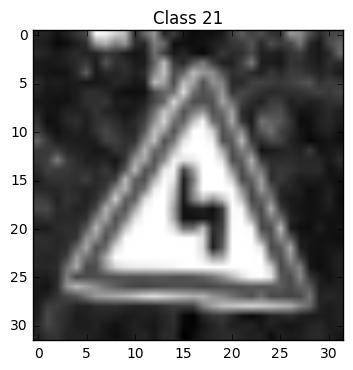

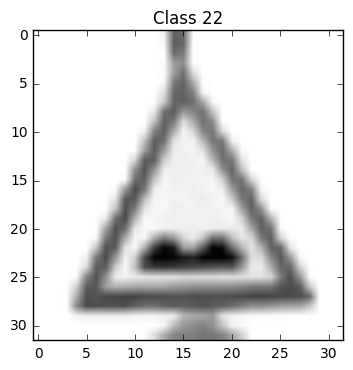

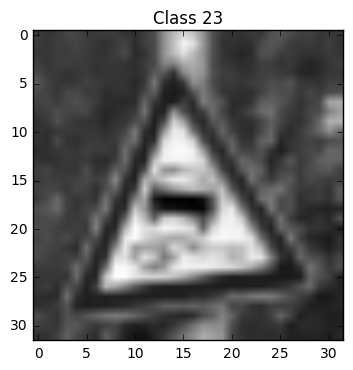

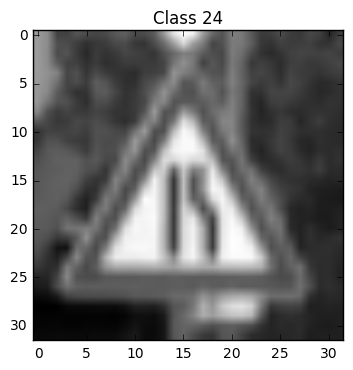

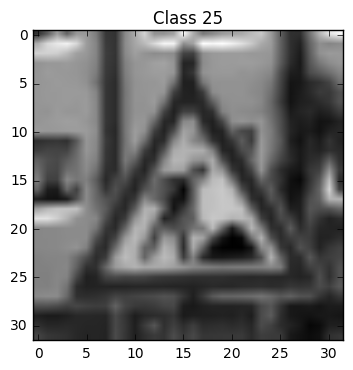

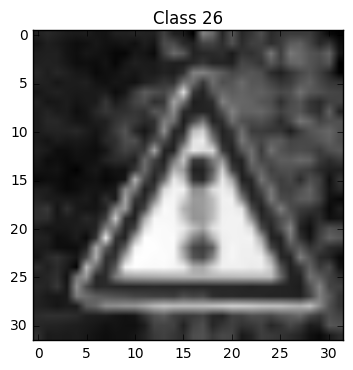

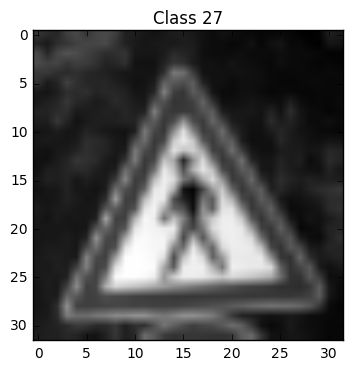

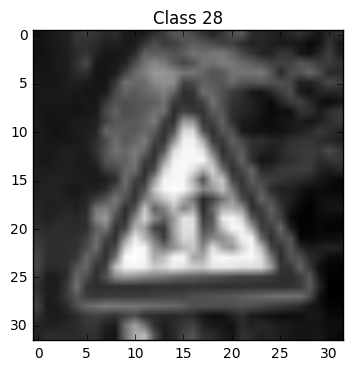

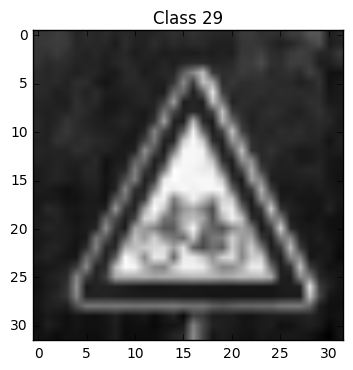

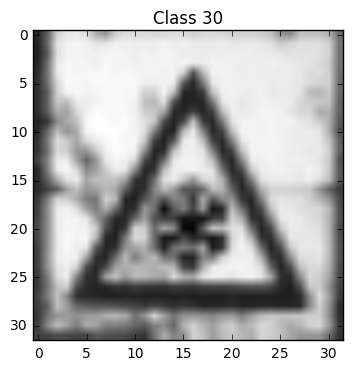

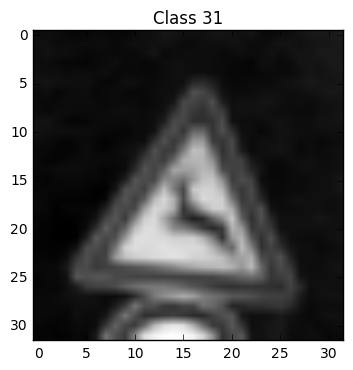

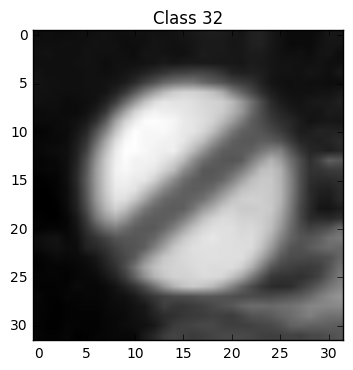

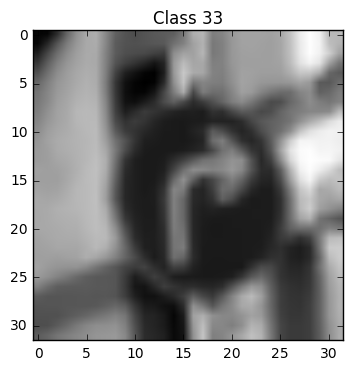

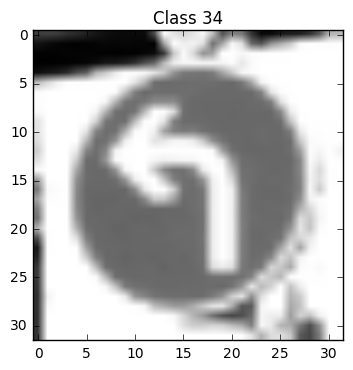

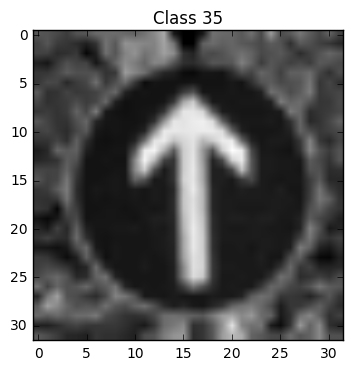

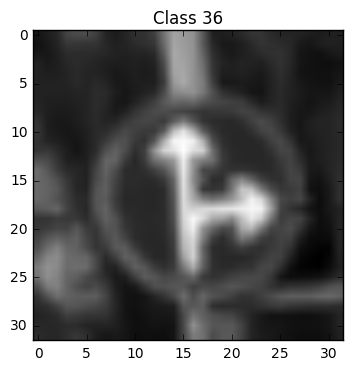

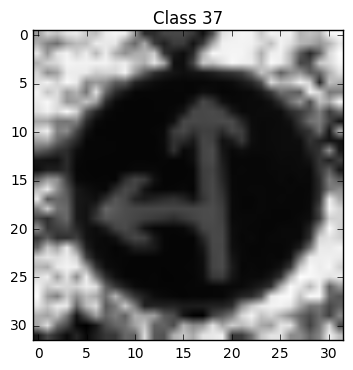

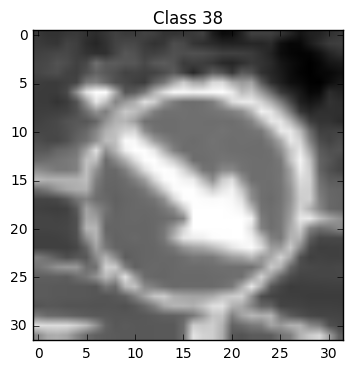

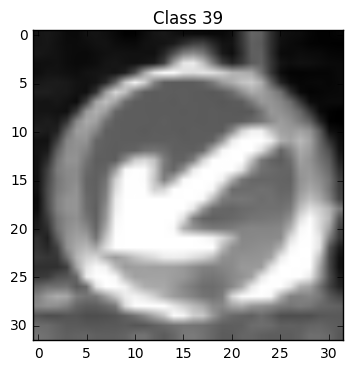

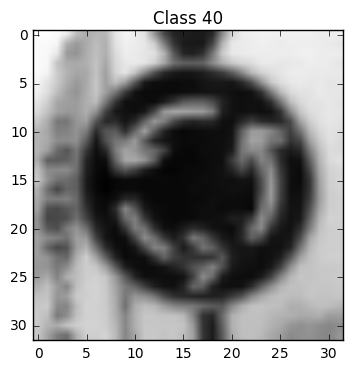

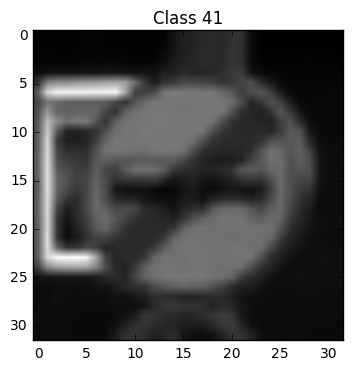

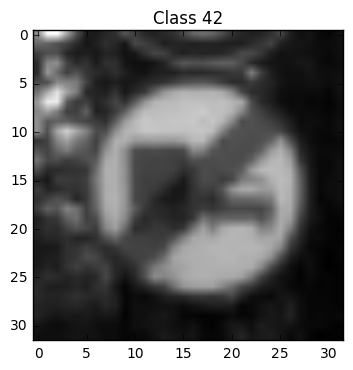

In [10]:
# plot one grayscale image per class
plot_images(X_train_gray, y_train, clear_image_indices, grayscale=True)

In [11]:
###Data synthesis
# flip these vertically
horizontal_symmetric_classes = set([12, 15, 17])

# flip these horizontally
vertical_symmetric_classes = set([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])

# class [key] flipped horizontally is class [value]
mirror_classes = {19: 20, 20: 19, 33: 34, 34: 33, 36: 37, 37: 36, 38: 39, 39: 38}

In [12]:
def synthesize_images(X, y, classes, symmetry='horizontal', example_index=0):
    s = []
    for i in range(len(X)):
        if y[i] in classes:
            s.append(i)

    shape = list(X.shape)
    shape[0] = len(s)
    X_train_syn = np.zeros(shape=shape)
    y_train_syn = np.zeros(shape=shape[0])

    example_i = example_j = -1

    for j, i in enumerate(s):
        if example_j == -1 and i == example_index:
            example_i = i
            example_j = j
        if symmetry == 'horizontal':
            X_train_syn[j] = np.flipud(X[i])
        elif symmetry == 'vertical' or symmetry == 'mirror':
            X_train_syn[j] = np.fliplr(X[i])
        if symmetry == 'mirror':
            y_train_syn[j] = classes[y[i]]
        else:
            y_train_syn[j] = y[i]
    
    print 'Example indices: {}, {}'.format(example_i, example_j)
    print ''
    return X_train_syn, y_train_syn

In [13]:
# synthesize horizontally symmetric images
X_train_syn, y_train_syn = synthesize_images(X_train_gray, 
                                             y_train, 
                                             horizontal_symmetric_classes, 
                                             symmetry='horizontal',
                                             example_index=19100)


print ("Number of synthesized examples: {}".format(len(X_train_syn)))

# add synthesized images to training set
X_train_gray = np.concatenate((X_train_gray, X_train_syn))
y_train = np.concatenate((y_train, y_train_syn))

Example indices: 19100, 1100

Number of synthesized examples: 3840


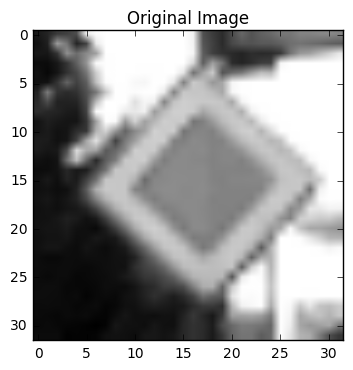

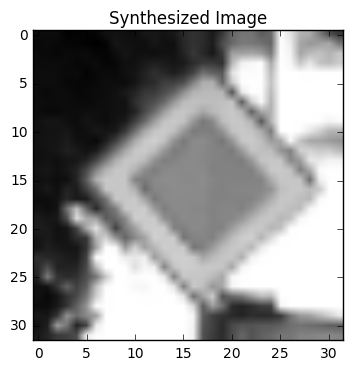

In [14]:
# plot example
plot_images(X_train_gray, y_train, [19100], grayscale=True, title='Original Image')
plot_images(X_train_syn, y_train, [1100], grayscale=True, title='Synthesized Image')

In [15]:
# synthesize vertically symmetric images
X_train_syn, y_train_syn = synthesize_images(X_train_gray, 
                                             y_train, 
                                             vertical_symmetric_classes, 
                                             symmetry='vertical',
                                             example_index=19100)

print ("Number of synthesized examples: {}".format(len(X_train_syn)))

# add synthesized images to training set
X_train_gray = np.concatenate((X_train_gray, X_train_syn))
y_train = np.concatenate((y_train, y_train_syn))

Example indices: 19100, 2420

Number of synthesized examples: 15000


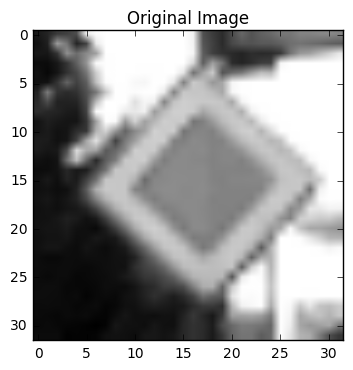

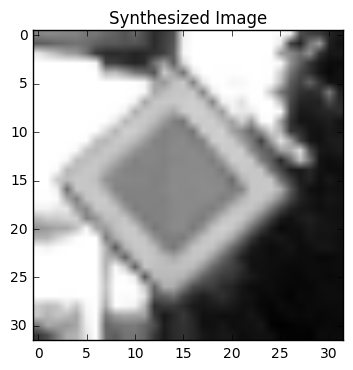

In [16]:
# plot example
plot_images(X_train_gray, y_train, [19100], grayscale=True, title='Original Image')
plot_images(X_train_syn, y_train, [2420], grayscale=True, title='Synthesized Image')

In [17]:
# synthesize mirror images
X_train_syn, y_train_syn = synthesize_images(X_train_gray, 
                                             y_train, 
                                             mirror_classes, 
                                             symmetry='mirror',
                                             example_index=35960)

print ("Number of synthesized examples: {}".format(len(X_train_syn)))

# add synthesized images to training set
X_train_gray = np.concatenate((X_train_gray, X_train_syn))
y_train = np.concatenate((y_train, y_train_syn)).astype(np.uint8)

Example indices: 35960, 2240

Number of synthesized examples: 4649


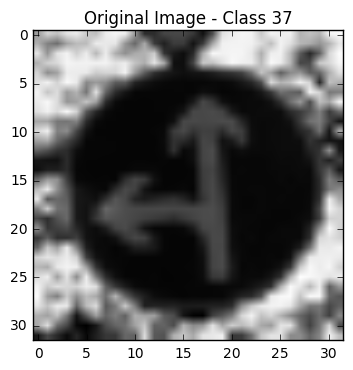

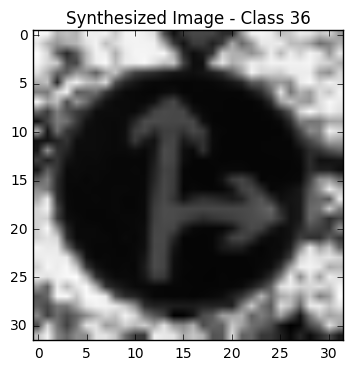

In [18]:
# plot example
plot_images(X_train_gray, y_train, [35960], grayscale=True, title='Original Image - Class 37')
plot_images(X_train_syn, y_train, [2240], grayscale=True, title='Synthesized Image - Class 36')

In [19]:
print ('Total number of synthesized training examples: {}'.format(len(X_train_gray) - len(X_train)))
print ('Total number of training examples: {}'.format(len(X_train_gray)))

Total number of synthesized training examples: 23489
Total number of training examples: 62698


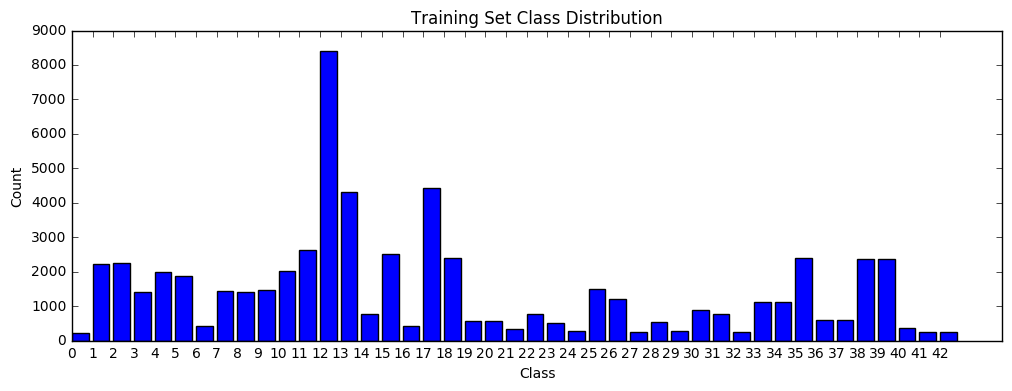

In [20]:
# display new training set class distribution
class_distribution(y_train, 'Training Set Class Distribution')

In [42]:
# Flatten data to shape [n_samples, n_features] for support vector classifier

def flatten_(data):
    if len(data.shape) <= 2:
        return data
    d = 1
    for i in range(1, len(data.shape)):
        d *= data.shape[i]
    data_flat = data.reshape(data.shape[0], d)
    return data_flat

In [22]:
X_train_svm = flatten_(X_train_gray)
y_train_svm = np.copy(y_train)
X_test_svm = flatten_(X_test_gray)

In [23]:
## SVM Training 
# shuffle the training set
X_train_svm, y_train_svm = shuffle(X_train_svm, y_train_svm, random_state=1)

In [24]:
# split training set into new training set and validation set
X_train_svm_new, X_cv_svm, y_train_svm_new, y_cv_svm = train_test_split(X_train_svm, 
                                                                        y_train_svm, 
                                                                        test_size=0.24, 
                                                                        random_state=2)

In [25]:
# train SVC on new training set
svc = SVC(random_state=3)
svc.fit(X_train_svm_new, y_train_svm_new)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=3, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
# test SVC on validation set
y_pred = svc.predict(X_cv_svm)

In [27]:
# print accuracy score
score = accuracy_score(y_pred, y_cv_svm)
print score

0.775518341308


In [28]:
# tune parameters by training and testing 9 SVMs on validation set, each with different C and gamma parameters
C_grid = [1, 10, 100]
g_grid = ['auto', .01, .1]

best_C = 1
best_g = 'auto'
best_score = score

for C in C_grid:
    for g in g_grid:
        if C == 1 and g == 'auto':
            continue
        svc = SVC(C=C, gamma=g, random_state=4)
        svc.fit(X_train_svm_new, y_train_svm_new)
        y_pred = svc.predict(X_cv_svm)
        score = accuracy_score(y_pred, y_cv_svm)
        print 'C: {}'.format(C)
        print 'gamma: {}'.format(g)
        print 'accuracy score: {}'.format(score)
        print ''
        if score > best_score:
            best_C = C
            best_g = g
            best_score = score

print ("Best C: {}".format(best_C))
print ("Best gamma: {}".format(best_g))
print ("Best accuracy score: {}".format(best_score))

C: 1
gamma: 0.01
accuracy score: 0.906034024455

C: 1
gamma: 0.1
accuracy score: 0.516414141414

C: 10
gamma: auto
accuracy score: 0.928960659224

C: 10
gamma: 0.01
accuracy score: 0.95514354067

C: 10
gamma: 0.1
accuracy score: 0.552565124934

C: 100
gamma: auto
accuracy score: 0.963051568315

C: 100
gamma: 0.01
accuracy score: 0.95879851143

C: 100
gamma: 0.1
accuracy score: 0.552631578947

Best C: 100
Best gamma: auto
Best accuracy score: 0.963051568315


In [25]:
# train SVM with best parameters on entire training set
svc = SVC(C=best_C, gamma=best_g, random_state=5)
X_train_svm, y_train_svm = shuffle(X_train_svm, y_train_svm, random_state=6)
svc.fit(X_train_svm, y_train_svm)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=5, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
# test SVM
y_pred = svc.predict(X_test_svm)

In [27]:
# print accuracy score on test set
score = accuracy_score(y_pred, y_test)
print (score)

0.806096595408


In [32]:
##CNN MODEL BUILDER
# shuffle training data
X_train_gray, y_train = shuffle(X_train_gray, y_train, random_state=1)

In [33]:
# split training set into new training set and validation set
X_train_nn, X_cv_nn, y_train_nn, y_cv_nn = train_test_split(X_train_gray, 
                                                            y_train, 
                                                            test_size=0.24, 
                                                            random_state=2)

In [45]:
### LeNet-5 architecture
from tensorflow.contrib.layers import flatten

def LeNet(x, mu=0, sigma=0.1):
    x = tf.reshape(x, (-1, 32, 32, 1))

    # Convolution Layer 1. Input = 32x32x1. Output = 28x28x6.
    # (height, width, input_depth, output_depth)
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation 1.
    conv1 = tf.nn.relu(conv1)

    # Pooling Layer 1. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Convolution Layer 2. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation 2.
    conv2 = tf.nn.relu(conv2)

    # Pooling Layer 2. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten Layer.
    fc1 = flatten(conv2)
    fc1_shape = (fc1.get_shape().as_list()[-1], 120)

    # Fully Connected Layer 1. Input = 5x5x16. Output = 120.
    fc1_W     = tf.Variable(tf.truncated_normal(shape=(fc1_shape), mean=mu, stddev=sigma))
    fc1_b     = tf.Variable(tf.zeros(120))
    fc1       = tf.matmul(fc1, fc1_W) + fc1_b

    # Activation 3.
    fc1 = tf.nn.relu(fc1)

    # Fully Connected Layer 2. Input = 120. Output = 43.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean=mu, stddev=sigma))
    fc2_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc1, fc2_W) + fc2_b

    return logits

In [46]:
# x = tf.placeholder(tf.float32, (None, 32, 32, 3))
x = tf.placeholder(tf.float32, (None, 32, 32))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [47]:
# define learning rate, logits, loss, optimizer

learning_rate = 0.001
logits = LeNet(x)
softmax = tf.nn.softmax(logits)
loss_operation = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [48]:
def initialize():
    global x, y, one_hot_y, learning_rate, logits, softmax, loss_operation, optimizer, training_operation, correct_prediction, accuracy_operation
    x = tf.placeholder(tf.float32, (None, 32, 32))
    y = tf.placeholder(tf.int32, (None))
    one_hot_y = tf.one_hot(y, n_classes)
    learning_rate = 0.001
    logits = LeNet(x)
    softmax = tf.nn.softmax(logits)
    loss_operation = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_operation = optimizer.minimize(loss_operation)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [38]:
# get loss and accuracy of model on validation or test set

def evaluate(X_data, y_data, batch_size=-1):
    X_data, y_data = shuffle(X_data, y_data, random_state=10)
    num_examples = len(X_data)
    total_accuracy, total_loss = 0, 0
    sess = tf.get_default_session()
    if batch_size == -1:
        batch_size = int(round(len(X_data) / 50))
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        loss, accuracy =  sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * batch_x.shape[0])
        total_loss     += (loss * batch_x.shape[0])
    return total_loss / num_examples, total_accuracy / num_examples

In [39]:
# train neural net

def train_model(X_train, y_train, X_cv=None, y_cv=None, epochs=100, batch_size=100):
    tf.reset_default_graph()
    initialize()
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
#         print "Training..."
#         print
        num_examples = len(X_train)
        best_epoch = 0
        max_accuracy = 0.
        min_loss = float('inf')
        batch_size = batch_size
        for i in range(epochs):
            X_train, y_train = shuffle(X_train, y_train, random_state=11)
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                # print(batch_x.shape)
                loss = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            if X_cv is not None:
                validation_loss, validation_accuracy = evaluate(X_cv, y_cv, batch_size=batch_size)
#                 print "EPOCH {} ...".format(i + 1)
#                 print "Validation Loss     = {:.3f}".format(validation_loss)
#                 print "Validation Accuracy = {:.3f}".format(validation_accuracy)
                if validation_accuracy > max_accuracy:
                    best_epoch = i
                    max_accuracy = validation_accuracy
                    min_loss = min(min_loss, validation_loss)
                elif max_accuracy == validation_accuracy and validation_loss < min_loss:
                    best_epoch = i
                    min_loss = validation_loss
#             else:
#                 print "EPOCH {} ...".format(i + 1)
#             print

        try:
            saver
        except NameError:
            saver = tf.train.Saver()
        saver.save(sess, 'lenet')
#         print "Model saved"
        
        if X_cv is not None:
            return best_epoch

In [127]:
# tune parameters by training and testing 9 ConvNets on validation set, each with different batch and epoch parameters

batch_grid = [20, 40, 80]
epoch_grid = [20, 40, 80]

best_batch = -1
best_epoch = -1
best_score = 0

for b in batch_grid:
    for e in epoch_grid:
        train_model(X_train_nn, y_train_nn, epochs=e, batch_size=b)
        with tf.Session() as sess:
            loader = tf.train.import_meta_graph('lenet.meta')
            loader.restore(sess, tf.train.latest_checkpoint('./'))
            test_loss, score = evaluate(X_cv_nn, y_cv_nn, batch_size=best_batch)
        print ('batch: {}'.format(b))
        print ('epoch: {}'.format(e))
        print ('accuracy score: {}'.format(score))
        print ('')
        if score > best_score:
            best_score = score
            best_batch = b
            best_epoch = e

print ("Best batch: {}".format(best_batch))
print ("Best epoch: {}".format(best_epoch))
print ("Best accuracy score: {}".format(best_score))

batch: 20
epoch: 20
accuracy score: 0.987971833781

batch: 20
epoch: 40
accuracy score: 0.986509831978

batch: 20
epoch: 80
accuracy score: 0.987573096452

batch: 40
epoch: 20
accuracy score: 0.987174372354

batch: 40
epoch: 40
accuracy score: 0.987573096611

batch: 40
epoch: 80
accuracy score: 0.992490694648

batch: 80
epoch: 20
accuracy score: 0.987506652246

batch: 80
epoch: 40
accuracy score: 0.988902186631

batch: 80
epoch: 80
accuracy score: 0.993088787094

Best batch: 80
Best epoch: 80
Best accuracy score: 0.993088787094


In [128]:
# train ConvNet with best parameters
train_model(X_train_gray, y_train, epochs=best_epoch, batch_size=best_batch)

In [133]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_loss, test_accuracy = evaluate(X_test_gray, y_test, batch_size=best_batch)
    # print("Test Loss     = {:.3f}".format(test_loss))
    print ("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.927
